In [1]:
## All necessary library imports

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn.init as init
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
torch.manual_seed(42)
import torch.nn as nn

import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import io
from torchvision import models
from torchsummary import summary

# PART-III: Implementing & Improving AlexNet

## Step-1: Loading, preprocessing, analyzing the dataset and making it ready for training

In [2]:
# Define the path to the folder containing the image dataset
data_dir = 'cnn_dataset'

# Define the transforms to be applied to the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the entire dataset using the ImageFolder class
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

BATCH_SIZE = 128
# Create dataloaders for each dataset
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
}

# Find the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the tensors to the found device
for x in ['train', 'val', 'test']:
    for inputs, labels in dataloaders[x]:
        inputs = inputs.to(device)
        labels = labels.to(device)

# Print the size of each dataset
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
print(dataset_sizes)


{'train': 21000, 'val': 6000, 'test': 3000}


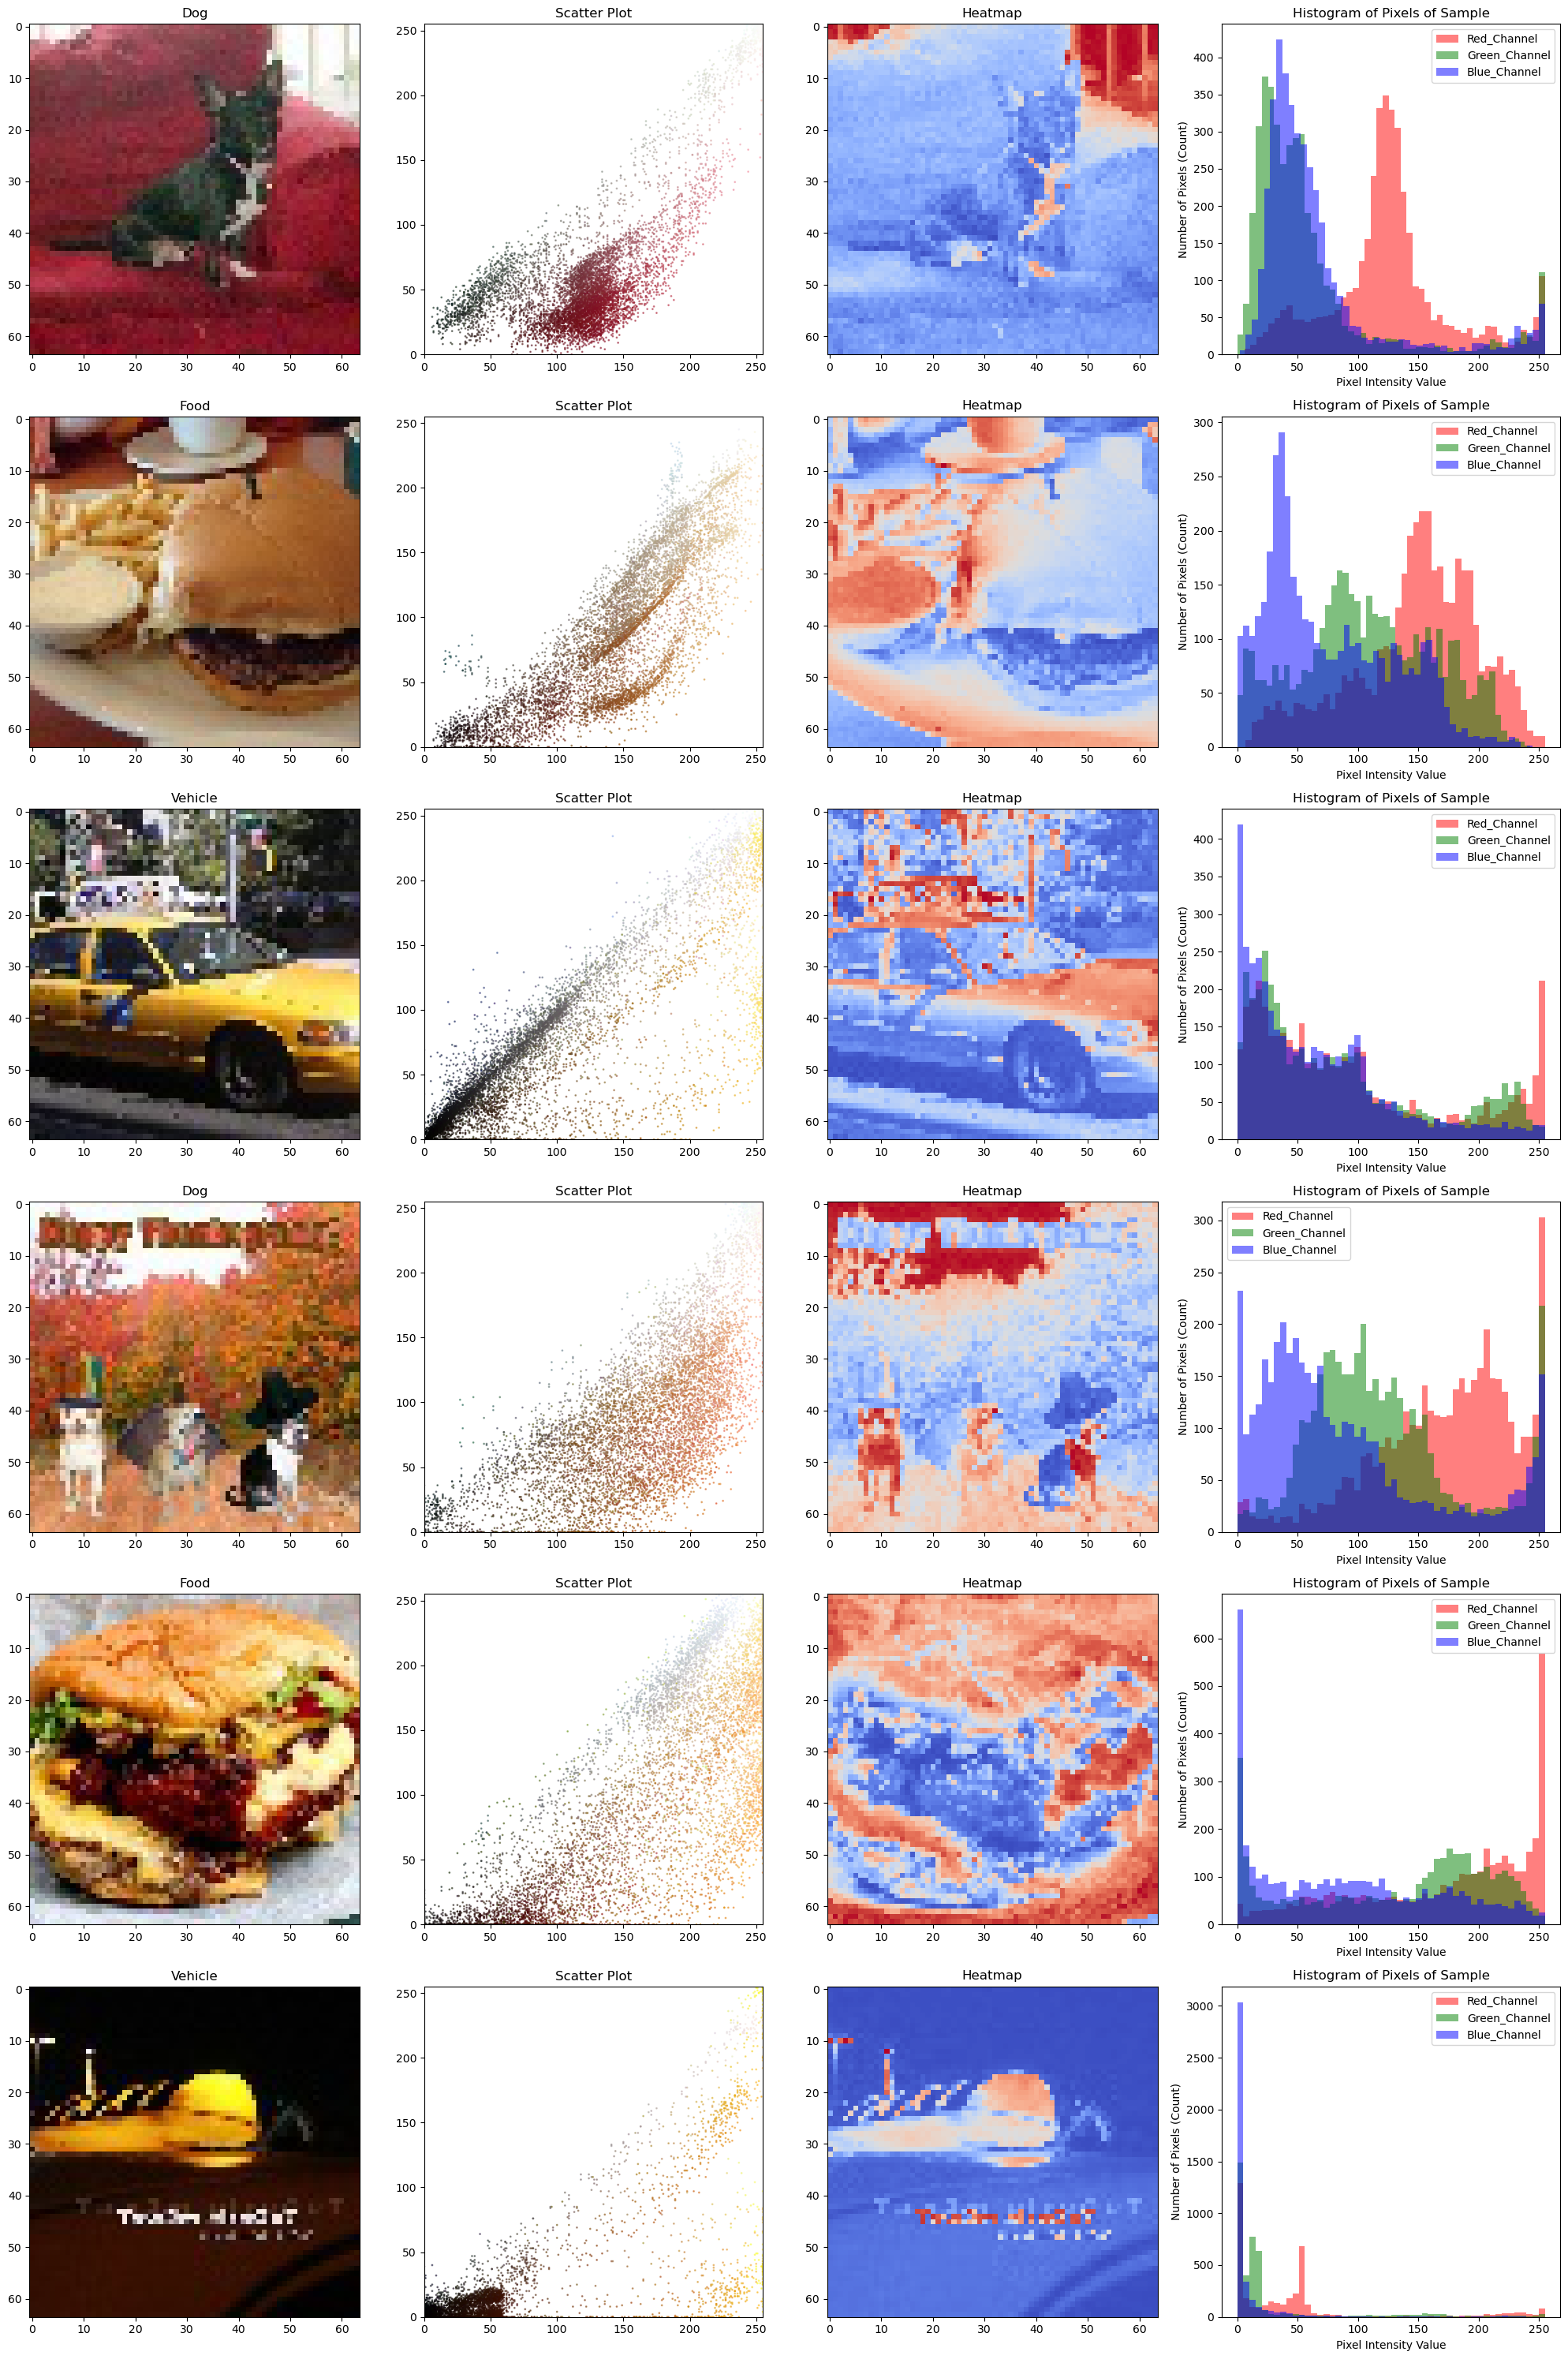

In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np

data_dir = 'cnn_dataset'

def image_visualization(img, title, ax):
    # Plot the original image
    ax[0].imshow(img)
    ax[0].set_title(title)

    # Plot the scatter plot
    flat_array = img.reshape(-1, 3)
    ax[1].scatter(flat_array[:, 0], flat_array[:, 1], s=1, c=flat_array/255.0, alpha=0.5)
    ax[1].scatter(flat_array[:, 0], flat_array[:, 2], s=1, c=flat_array/255.0, alpha=0.5)
    ax[1].set_xlim([0, 255])
    ax[1].set_ylim([0, 255])
    ax[1].set_title('Scatter Plot')

    # Plot the heatmap
    img_gray = np.mean(img, axis=2)
    ax[2].imshow(img_gray, cmap='coolwarm')
    ax[2].set_title('Heatmap')

    # Plot the histogram
    ax[3].hist(img[:, :, 0].ravel(), bins = 50, color = 'red', alpha = 0.5)
    ax[3].hist(img[:, :, 1].ravel(), bins = 50, color = 'Green', alpha = 0.5)
    ax[3].hist(img[:, :, 2].ravel(), bins = 50, color = 'Blue', alpha = 0.5)
    ax[3].set_xlabel('Pixel Intensity Value')
    ax[3].set_ylabel('Number of Pixels (Count)')
    ax[3].legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
    ax[3].set_title(f'Histogram of Pixels of Sample')

# Plot the images
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))

dog_img = plt.imread(os.path.join(data_dir, 'dogs', '1.jpg'))
image_visualization(dog_img, 'Dog', [axes[0,0], axes[0,1], axes[0,2], axes[0,3]])

food_img = plt.imread(os.path.join(data_dir, 'food', '1.jpg'))
image_visualization(food_img, 'Food', [axes[1,0], axes[1,1], axes[1,2], axes[1,3]])

vehicle_img = plt.imread(os.path.join(data_dir, 'vehicles', '1.jpg'))
image_visualization(vehicle_img, 'Vehicle', [axes[2,0], axes[2,1], axes[2,2], axes[2,3]])

dog_img = plt.imread(os.path.join(data_dir, 'dogs', '2.jpg'))
image_visualization(dog_img, 'Dog', [axes[3,0], axes[3,1], axes[3,2], axes[3,3]])

food_img = plt.imread(os.path.join(data_dir, 'food', '2.jpg'))
image_visualization(food_img, 'Food', [axes[4,0], axes[4,1], axes[4,2], axes[4,3]])

vehicle_img = plt.imread(os.path.join(data_dir, 'vehicles', '2.jpg'))
image_visualization(vehicle_img, 'Vehicle', [axes[5,0], axes[5,1], axes[5,2], axes[5,3]])

plt.tight_layout()
plt.show()


## Step-2: Building AlexNet architecture 

In [2]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequen

In [3]:
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
         MaxPool2d-3           [-1, 96, 26, 26]               0
 LocalResponseNorm-4           [-1, 96, 26, 26]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
              ReLU-6          [-1, 256, 26, 26]               0
         MaxPool2d-7          [-1, 256, 12, 12]               0
 LocalResponseNorm-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]         885,120
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]       1,327,488
             ReLU-12          [-1, 384, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         884,992
             ReLU-14          [-1, 256,

## Step-3: Training and Evaluating the Performance of AlexNet

### Model Train, Validation and Test functions for Part-III and Part-IV

In [6]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (train_images, train_labels) in enumerate(train_loader):
        train_images = train_images.to(device)
        train_labels = train_labels.to(device)
        optimizer.zero_grad()
        train_outputs = model(train_images)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()
        _, predicted = train_outputs.max(1)
        total += train_labels.size(0)
        correct += predicted.eq(train_labels).sum().item()
    average_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return average_loss, train_accuracy


def validate(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_images.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            total_val += val_labels.size(0)
    val_acc = 100.0 * val_correct / total_val
    val_loss = val_loss / total_val
    return val_acc, val_loss

def test(model, criterion, test_loader, model_path, device):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total_test = 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_images)
            loss = criterion(test_outputs, test_labels)
            test_loss += loss.item() * test_images.size(0)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_correct += (test_predicted == test_labels).sum().item()
            total_test += test_labels.size(0)
    test_acc = 100.0 * test_correct / total_test
    test_loss = test_loss / total_test
    return test_acc, test_loss


### User-defined Plot function for plotting training, validation loss and accuracies plots

In [7]:
def plot_fn(train_loss,val_loss,train_acc,val_acc):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the training and test loss on the same plot
    ax2.plot(train_loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Plot the training and test accuracy on the same plot
    ax1.plot(train_acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validattion Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Display the plot
    plt.show()

### Code block which calls model training, validation, testing and plotting functions. 

Epoch 1--------------------------------------------------
Train Loss: 1.04 - Validation Loss: 0.87
Train Accuracy: 43.01% - Validation Accuracy: 60.23%
Epoch 2--------------------------------------------------
Train Loss: 0.73 - Validation Loss: 0.68
Train Accuracy: 67.28% - Validation Accuracy: 71.67%
Epoch 3--------------------------------------------------
Train Loss: 0.63 - Validation Loss: 0.57
Train Accuracy: 73.93% - Validation Accuracy: 76.25%
Epoch 4--------------------------------------------------
Train Loss: 0.56 - Validation Loss: 0.50
Train Accuracy: 77.55% - Validation Accuracy: 79.62%
Epoch 5--------------------------------------------------
Train Loss: 0.51 - Validation Loss: 0.50
Train Accuracy: 79.76% - Validation Accuracy: 81.20%
Epoch 6--------------------------------------------------
Train Loss: 0.49 - Validation Loss: 0.48
Train Accuracy: 80.11% - Validation Accuracy: 81.15%
Epoch 7--------------------------------------------------
Train Loss: 0.46 - Validation 

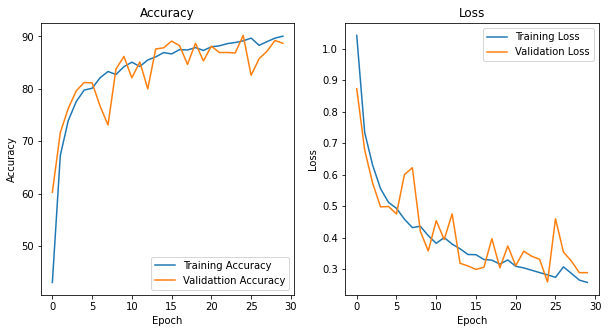

Test Loss: 0.25 -Test Accuracy: 90.73%


In [8]:
## This block runs for user-defined number of epochs

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define the model and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# set up training and validation dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)

# train the model
num_epochs = 30
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model.to(device), criterion, optimizer, train_loader, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
   
    val_acc, val_loss = validate(model.to(device), criterion, val_loader, device)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
   
    print(f"Epoch {epoch+1}--------------------------------------------------")
    print(f"Train Loss: {train_loss:.2f} - Validation Loss: {val_loss:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}% - Validation Accuracy: {val_acc:.2f}%")
   
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')

plot_fn(train_losses,val_losses,train_accs,val_accs)


# test the model on the test set
model_path = 'best_model.pt'
test_acc, test_loss = test(model.to(device), criterion, test_loader, model_path, device)
print(f"Test Loss: {test_loss:.2f} -Test Accuracy: {test_acc:.2f}%")

## Part-III Step-3 Original AlexNet-->TEST ACCURACY: 90.73%

## Step-4: Modifying AlexNet structure for Improvement in Accuracy

### Improvement Methods used: Batch Normalization, Learning Rate Scheduler and Early Stopping

### Modified AlexNet architecture

In [8]:
## BatchNormalization layers are added after Convolution layers

import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (5): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (10): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(384,

In [9]:
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
       BatchNorm2d-2           [-1, 96, 54, 54]             192
              ReLU-3           [-1, 96, 54, 54]               0
         MaxPool2d-4           [-1, 96, 26, 26]               0
 LocalResponseNorm-5           [-1, 96, 26, 26]               0
            Conv2d-6          [-1, 256, 26, 26]         614,656
       BatchNorm2d-7          [-1, 256, 26, 26]             512
              ReLU-8          [-1, 256, 26, 26]               0
         MaxPool2d-9          [-1, 256, 12, 12]               0
LocalResponseNorm-10          [-1, 256, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]         885,120
      BatchNorm2d-12          [-1, 384, 12, 12]             768
             ReLU-13          [-1, 384, 12, 12]               0
           Conv2d-14          [-1, 384,

### Learning-Rate Scheduler

In [10]:
class CustomLR:
    def __init__(self, optimizer, initial_lr, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        new_lr = self.initial_lr * (1 - self.current_epoch / self.total_epochs)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

### Step-5: Train the NN and performance testing

### Code block that calls train, test, validate and plot functions along with Learning rate scheduler and Early stopping implemented

Epoch 1--------------------------------------------------
Train Loss: 0.28 - Validation Loss: 0.39
Train Accuracy: 89.54% - Validation Accuracy: 85.30%
Epoch 2--------------------------------------------------
Train Loss: 0.30 - Validation Loss: 0.26
Train Accuracy: 88.70% - Validation Accuracy: 90.63%
Epoch 3--------------------------------------------------
Train Loss: 0.27 - Validation Loss: 0.28
Train Accuracy: 89.88% - Validation Accuracy: 90.22%
Epoch 4--------------------------------------------------
Train Loss: 0.25 - Validation Loss: 0.36
Train Accuracy: 90.22% - Validation Accuracy: 87.83%
Epoch 5--------------------------------------------------
Train Loss: 0.25 - Validation Loss: 0.30
Train Accuracy: 90.50% - Validation Accuracy: 88.72%
Epoch 6--------------------------------------------------
Train Loss: 0.23 - Validation Loss: 0.38
Train Accuracy: 91.05% - Validation Accuracy: 86.47%
Epoch 7--------------------------------------------------
Train Loss: 0.24 - Validation 

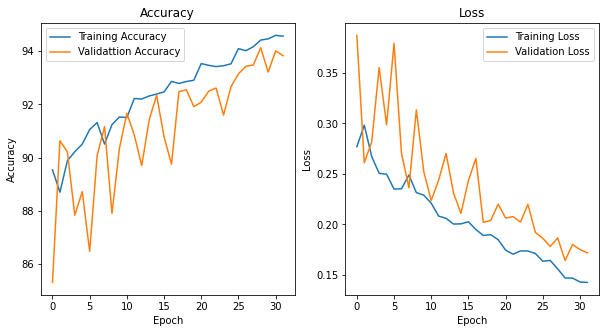

Test Loss: 0.17 -Test Accuracy: 93.63%


In [12]:

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define the model and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CustomLR(optimizer, initial_lr=0.01, total_epochs=num_epochs)

# set up training and validation dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)

# train the model
num_epochs = 32
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
counter = 0

patience = 8

for epoch in range(num_epochs):
    train_loss, train_acc = train(model.to(device), criterion, optimizer, train_loader, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_acc, val_loss = validate(model.to(device), criterion, val_loader, device)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}--------------------------------------------------")
    print(f"Train Loss: {train_loss:.2f} - Validation Loss: {val_loss:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}% - Validation Accuracy: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        counter = 0
    else:
        counter += 1

    # Update the learning rate scheduler
    scheduler.step()

    if counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break
        
plot_fn(train_losses, val_losses, train_accs, val_accs)

# test the model on the test set
model_path = 'best_model.pt'
test_acc, test_loss = test(model.to(device), criterion, test_loader, model_path, device)
print(f"Test Loss: {test_loss:.2f} -Test Accuracy: {test_acc:.2f}%")


## Part-III Step-4 Improved AlexNet-->TEST ACCURACY: 93.63%

# PART-IV:  Optimizing CNN + Data Argumentation for SVHN Dataset

In [13]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

### Step-1 and 3:  Loading, preprocessing,  Data Augmentation and analyzing the dataset and making it ready for training


#### Note: Data Augmentation is performed after loading the dataset in the below cell

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import SVHN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transforms for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define transforms for validation and testing (without data augmentation)
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the datasets
train_dataset = SVHN('./data', split='train', download=True, transform=train_transform)

# Load an extra validation set of SVHN dataset
extra_val_dataset = SVHN('./data', split='extra', download=True, transform=val_transform)

# Concatenate the original train dataset and extra validation set for val_dataset
val_dataset = ConcatDataset([train_dataset, extra_val_dataset])

# Load the test dataset
test_dataset = SVHN('./data', split='test', download=True, transform=val_transform)

# Define data transformations for the AUGMENTED dataset
aug_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an augmented version of the train dataset
aug_train_dataset = SVHN(root='./data', split='train', download=True, transform=aug_transform)

# Concatenate the original and augmented train datasets
concat_train_dataset = ConcatDataset([train_dataset, aug_train_dataset])

# Define data generators for the concatenated train set, validation set, and test set
batch_size = 128
num_workers = 30
train_loader = DataLoader(concat_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Define test_transform with normalization parameters from train_transform
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define test data loader with proper scaling as train
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Using downloaded and verified file: ./data\extra_32x32.mat


### Image visualization

Using downloaded and verified file: ./data\train_32x32.mat


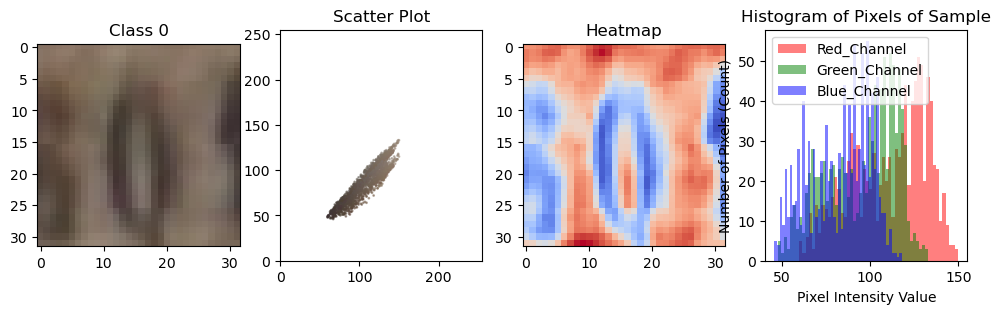

<Figure size 640x480 with 0 Axes>

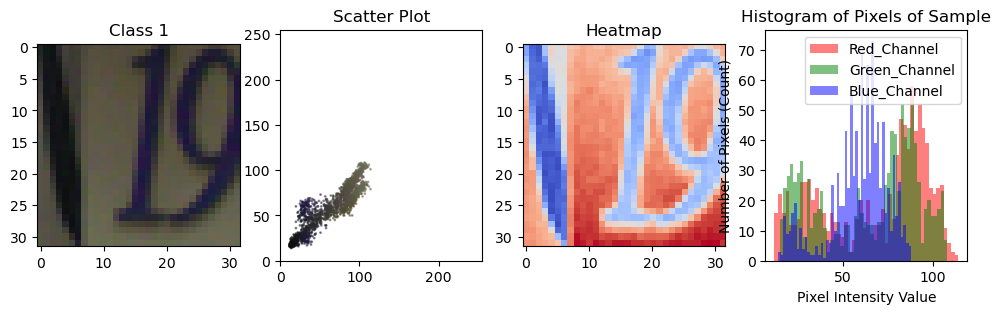

<Figure size 640x480 with 0 Axes>

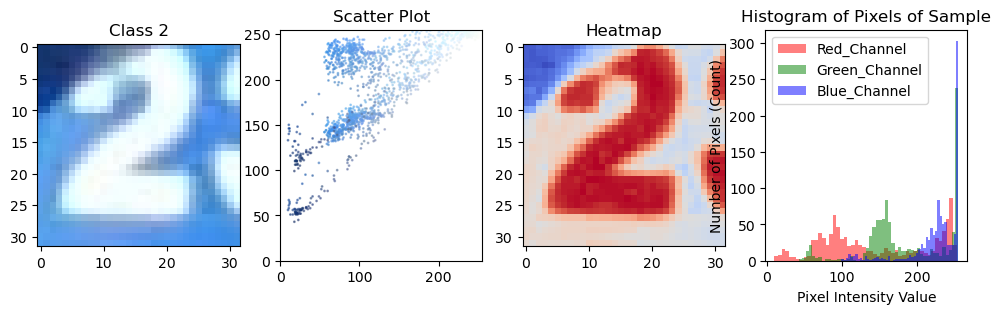

<Figure size 640x480 with 0 Axes>

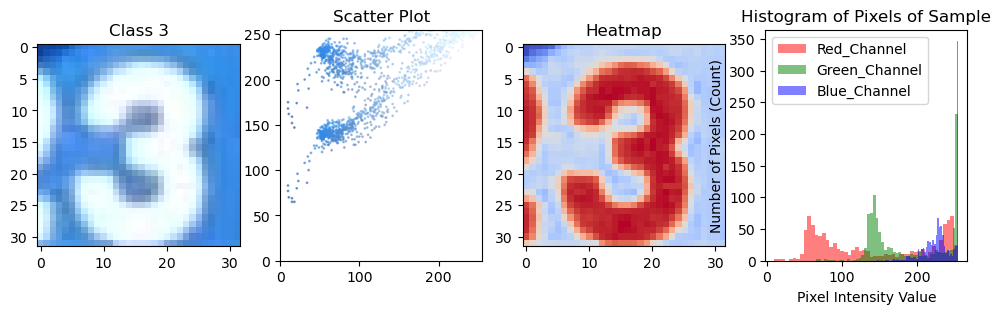

<Figure size 640x480 with 0 Axes>

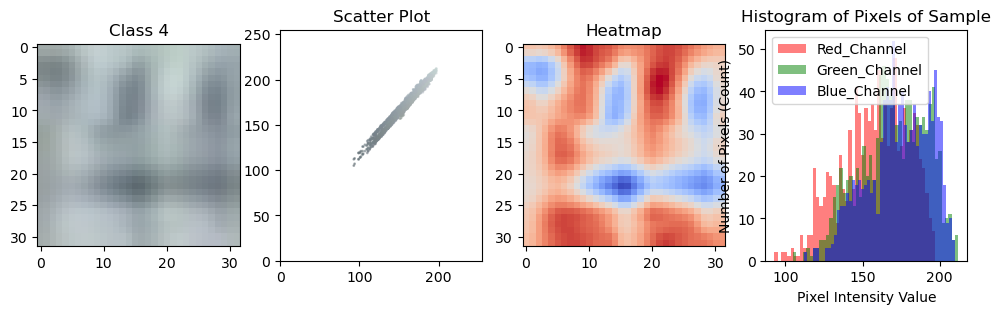

<Figure size 640x480 with 0 Axes>

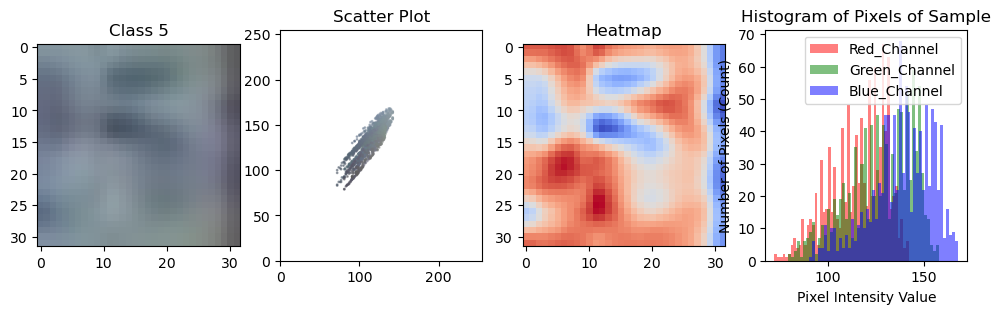

<Figure size 640x480 with 0 Axes>

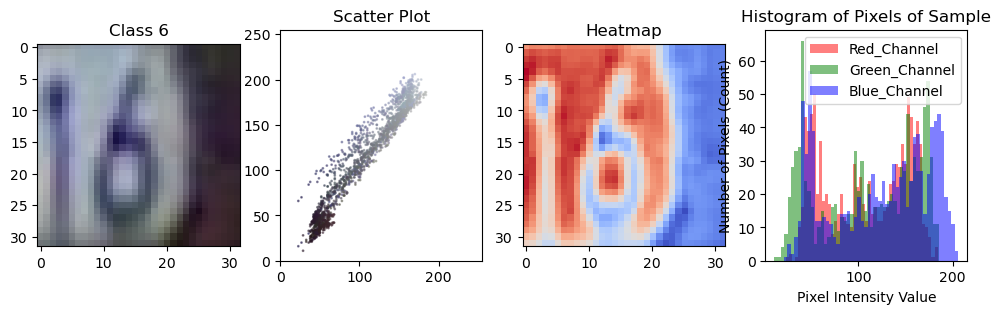

<Figure size 640x480 with 0 Axes>

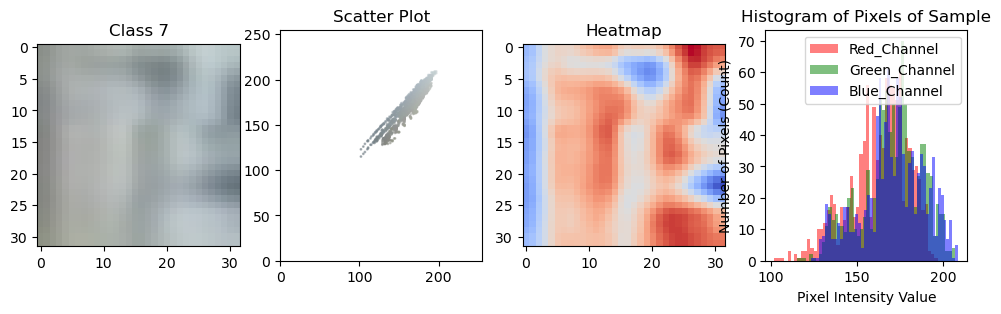

<Figure size 640x480 with 0 Axes>

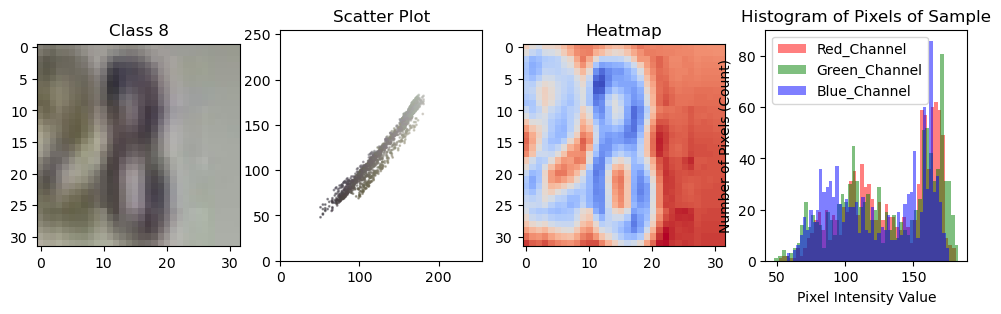

<Figure size 640x480 with 0 Axes>

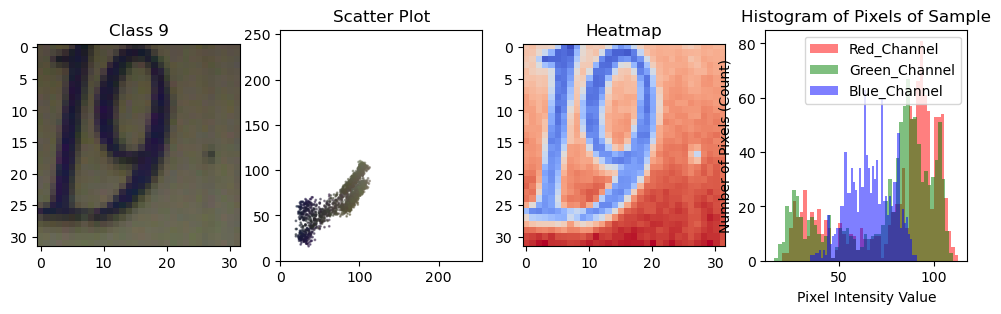

<Figure size 640x480 with 0 Axes>

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
import seaborn as sns
# Load the SVHN train set
svhn_trainset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=None)

# Create a dictionary to store one image per class
class_images = {}

# Loop through the train set and store one image per class
for i in range(len(svhn_trainset)):
    image, label = svhn_trainset[i]
    if label not in class_images:
        class_images[label] = image

# Plot one image per class
for i in range(10):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    # Plot the original image
    img = np.array(class_images[i])
    axs[0].imshow(img)
    axs[0].set_title(f'Class {i}')

    # Plot the scatter plot
    flat_array = img.reshape(-1, 3)
    axs[1].scatter(flat_array[:, 0], flat_array[:, 1], s=1, c=flat_array/255.0, alpha=0.5)
    axs[1].scatter(flat_array[:, 0], flat_array[:, 2], s=1, c=flat_array/255.0, alpha=0.5)
    axs[1].set_xlim([0, 255])
    axs[1].set_ylim([0, 255])
    axs[1].set_title('Scatter Plot')

    # Plot the heatmap
    img_gray = np.mean(img, axis=2)
    axs[2].imshow(img_gray, cmap='coolwarm')
    axs[2].set_title('Heatmap')

    # Plot the histogram

    
    # Plot the histograms of all three color channels on a single plot
    axs[3].hist(img[:, :, 0].ravel(), bins = 50, color = 'red', alpha = 0.5)
    axs[3].hist(img[:, :, 1].ravel(), bins = 50, color = 'Green', alpha = 0.5)
    axs[3].hist(img[:, :, 2].ravel(), bins = 50, color = 'Blue', alpha = 0.5)
    plt.xlabel('Pixel Intensity Value')
    plt.ylabel('Number of Pixels (Count)')
    plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.title(f'Histogram of Pixels of Sample')
    plt.show();

    plt.show()
    plt.clf()


### Step-2: Modified AlexNet architecure from Part-III

In [10]:

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (5): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
    (10): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(384,

In [11]:
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
       BatchNorm2d-2           [-1, 96, 54, 54]             192
              ReLU-3           [-1, 96, 54, 54]               0
         MaxPool2d-4           [-1, 96, 26, 26]               0
 LocalResponseNorm-5           [-1, 96, 26, 26]               0
            Conv2d-6          [-1, 256, 26, 26]         614,656
       BatchNorm2d-7          [-1, 256, 26, 26]             512
              ReLU-8          [-1, 256, 26, 26]               0
         MaxPool2d-9          [-1, 256, 12, 12]               0
LocalResponseNorm-10          [-1, 256, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]         885,120
      BatchNorm2d-12          [-1, 384, 12, 12]             768
             ReLU-13          [-1, 384, 12, 12]               0
           Conv2d-14          [-1, 384,

### Step-4: Train the network and evaluate the performance on the testing data

### Code block which calls Train, Validate, Test and Plot functions for Part-IV along with Learning rate scheduler and Early stopping implemented

Epoch 1--------------------------------------------------
Train Loss: 1.31 - Validation Loss: 0.80
Train Accuracy: 54.65% - Validation Accuracy: 74.14%
Epoch 2--------------------------------------------------
Train Loss: 0.56 - Validation Loss: 0.49
Train Accuracy: 82.03% - Validation Accuracy: 84.97%
Epoch 3--------------------------------------------------
Train Loss: 0.41 - Validation Loss: 0.38
Train Accuracy: 87.20% - Validation Accuracy: 88.25%
Epoch 4--------------------------------------------------
Train Loss: 0.35 - Validation Loss: 0.32
Train Accuracy: 89.26% - Validation Accuracy: 90.57%
Epoch 5--------------------------------------------------
Train Loss: 0.32 - Validation Loss: 0.29
Train Accuracy: 90.41% - Validation Accuracy: 91.46%
Epoch 6--------------------------------------------------
Train Loss: 0.29 - Validation Loss: 0.27
Train Accuracy: 91.20% - Validation Accuracy: 92.15%
Epoch 7--------------------------------------------------
Train Loss: 0.27 - Validation 

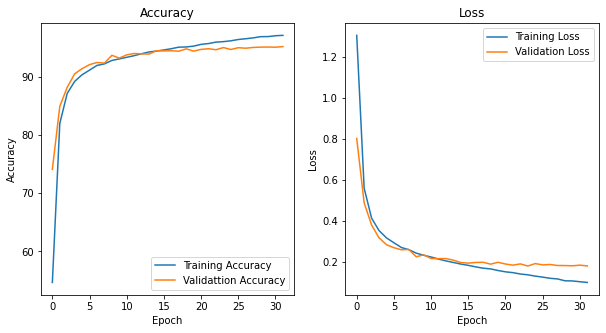

Test Loss: 0.18 -Test Accuracy: 95.31%


In [18]:
# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define the model and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = CustomLR(optimizer, initial_lr=0.01, total_epochs=num_epochs)

# set up training and validation dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=30)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=30)

# train the model
num_epochs = 32
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
counter = 0

patience = 8

for epoch in range(num_epochs):
    train_loss, train_acc = train(model.to(device), criterion, optimizer, train_loader, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_acc, val_loss = validate(model.to(device), criterion, val_loader, device)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}--------------------------------------------------")
    print(f"Train Loss: {train_loss:.2f} - Validation Loss: {val_loss:.2f}")
    print(f"Train Accuracy: {train_acc:.2f}% - Validation Accuracy: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        counter = 0
    else:
        counter += 1

    # Update the learning rate scheduler
    scheduler.step()

    if counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break
        
plot_fn(train_losses, val_losses, train_accs, val_accs)

# test the model on the test set
model_path = 'best_model.pt'
test_acc, test_loss = test(model.to(device), criterion, test_loader, model_path, device)
print(f"Test Loss: {test_loss:.2f} -Test Accuracy: {test_acc:.2f}%")


## Pat-IV Improved AlexNet-->TEST ACCURACY: 95.31%

## Contribution of Team Members

| Team Member | Assignment Part | Contribution (%) |
| --- | --- | --- |
| msikha | part-I step2 1, 2, 4 and part-II setups | 50% |
| zemingzh| part-I step 3 and part-II optimization methods | 50% |
